# Implement a custom Autoencoder with Koopman layer

## Setup

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import  numpy as np
import pandas as pd
import time

In [2]:
# Import hyperparameter tuning
import keras_tuner as kt

In [3]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
#from google.colab import drive
#drive.mount('/gdrive')

## Data

**Dyanmics of the Simple Pendulum**


![dynamics](\images\dynamics.PNG)


$\lambda = -1$
$\mu = -0.05$

In [5]:
discrete_train = pd.read_csv('data/DiscreteSpectrumExample_train1_x.csv', sep=',').values
discrete_test =pd.read_csv('data/DiscreteSpectrumExample_test_x.csv', sep=',').values
discrete_val = pd.read_csv('data/DiscreteSpectrumExample_val_x.csv', sep=',').values

In [6]:
# Normalize the data
min_val = tf.reduce_min(discrete_train)
max_val = tf.reduce_max(discrete_train)

discrete_train = (discrete_train - min_val) / (max_val - min_val)
discrete_test = (discrete_test - min_val) / (max_val - min_val)

train_data = tf.cast(discrete_train, tf.float32)
test_data = tf.cast(discrete_test, tf.float32)

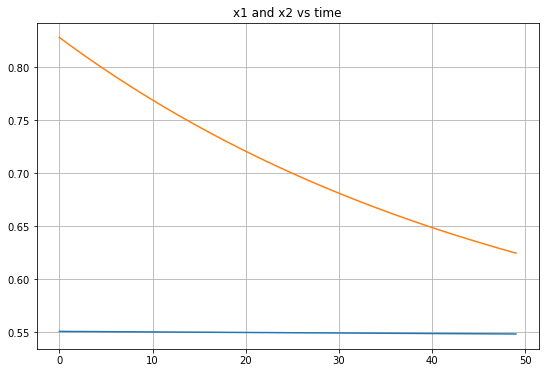

In [7]:
x_train = train_data[0:50,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

## Define the model

In [8]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a linear layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None, act='None'):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [9]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a linear layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b

In [10]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_tilde: tensor
        return the forward time shifted Z
    """

    def __init__(self, trajLength, numTraj):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj = numTraj
        

    def timeShift(self,Z):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data
            m: numpy element
                Batch size
        '''

        # ******** DO EVERYTHING IN TF OR TF SLICES ****************
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength])
            z1.append(Z[i*self.trajLength,:])

        # ********** GET INPUT SIZE ROBUSTLY ********************
        return tf.reshape(Z1, [-1, 64]), tf.reshape(Z2, [-1,64]), tf.reshape(z1, [-1,64])       

    def call(self, Z):
        Z1, Z2, z1 = self.timeShift(Z)
        # Find K
        K = tf.matmul(tf.transpose(Z2),tf.linalg.pinv(tf.transpose(Z1)))

        # Find Z2_tilde
        Z2_tilde = tf.zeros([500, 64], dtype=tf.float32)
        for traj in range(self.numTraj): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj
                 indices = tf.constant([[traj*self.trajLength]])
                 indices = tf.constant([[1]])
                 if m == 0: 
                     updates = [tf.linalg.matvec(K, z1[0,:])]
                     tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    Ki = K
                    Ki = tf.matmul(Ki,K)
                    updates = [tf.linalg.matvec(Ki, z1[traj,:])]
                    tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                    
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(Z2-Z2_tilde))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))

        return Z, Z2_tilde

### Hyperparameter Tuning

In [11]:
num_batches = 2
batch_size = 510
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[0:batch_size*num_batches,:], train_data[0:batch_size*num_batches,:]))
train_dataset = train_dataset.batch(batch_size)
x_train = train_data[0:batch_size*num_batches]
y_train = train_data[0:batch_size*num_batches]

In [37]:
# Hyperparameter Class

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        inputs = tf.keras.layers.Input(shape=(2,))

        
        trajLength = int(51)
        numtraj = int(510/51)
        encoder_1 = EncoderLayer(16)
        encoder_2 = EncoderLayer(32)
        encoder_3 = EncoderLayer(64)
        koopman = KoopmanLayer(trajLength, numtraj)
        decoder_1 = DecoderLayer(32)
        decoder_2 = DecoderLayer(16)
        outputLayer = DecoderLayer(2)
        
        # input layer
        #x = x[:, :, tf.newaxis] #fixes dimension issues with input

        # encoding layers (linear layer)

        x = encoder_1(inputs) # Put hyperparameter input size
        x = tf.nn.elu(x)
        x = encoder_2(x)
        x = tf.nn.elu(x)
        x = encoder_3(x)
        z = tf.nn.elu(x)

        # koopman layer
        z, z2_tilde  = koopman(z)

        # decoding layers for x
        z, z2_tilde = decoder_1(z, z2_tilde)
        z = tf.nn.elu(z)
        z2_tilde = tf.nn.elu(z2_tilde)

        z,z2_tilde = decoder_2(z, z2_tilde)
        z = tf.nn.elu(z)
        z2_tilde = tf.nn.elu(z2_tilde)
        
        # output layer
        x_hat, x2_hat = outputLayer(z, z2_tilde)
        #x_hat = tf.nn.relu(z)

        # Build the model with one input and two outputs
        ae = tf.keras.models.Model(
            inputs=inputs, outputs=[x_hat, x2_hat], name="Deep_Koopman_Autoencoder")
        return ae




    def custom_loss(self, y_true, y_pred):
        """Calculates the Mean Squared Error between y_pred and y_true vectors"""
        return tf.reduce_mean(tf.abs(y_true-y_pred)) #avg loss for each batch since reduce_mean is already an avg

    def tot_loss(self, model, recon_loss):
        return recon_loss + sum(model.losses)




    def fit(self, hp, model, x, y, validation_data, callbacks=None, **kwargs):
        # Preprocess data

        batch_size = 510
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(
            batch_size
        )

        # Define weights that are trainable
        variables = model.variables

        # Define the optimizer
        optimizer = tf.keras.optimizers.SGD(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3))

        # Metric to track validation loss
        epoch_loss_metric = keras.metrics.Mean()
        epochs = 2

        def run_train_step(x_batch_train,y_batch_train):
            with tf.GradientTape() as tape:
                #batch_length =  len(x_batch_train) #num elements in each batch
                reconstruction, prediction = model(x_batch_train)
            
                # avg loss for each batch
                recon_loss =  self.custom_loss(y_batch_train, reconstruction)
                # predict_loss =  custom_loss(y_batch_train[1:,:], predictions)

                # total avg loss for each batch
                total = self.tot_loss(model, recon_loss)
                total_loss_batch.append(total)

            grads = tape.gradient(total, variables)
            optimizer.apply_gradients(zip(grads, variables))
            return total

        def run_val_step(x_batch_val,y_batch_val):
            reconstruction_val, pred_val = model(x_batch_val)
            recon_loss = self.custom_loss(y_batch_val, reconstruction_val)
            total = self.tot_loss(model, recon_loss)
            print("total val loss:", total)
            epoch_loss_metric.update_state(total)
        
        for callback in callbacks:
            callback.model = model
        
        best_epoch_val_loss = float("inf")
        
        total_loss = [] # total loss for each epoch
        for epoch in range(epochs):
            total_loss_batch = [] # ttal loss for each batch 
            #reconstruction_loss_batch = []
            #prediction_loss_batch = []
            
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                train_total = run_train_step(x_batch_train, y_batch_train)
                
                # Log every 100 batches.
                if step % 100 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(train_total))
                    )
                    print("Seen so far: %s samples" % ((step + 1) * batch_size))
            
            # outside batch loop
            total_loss_avg = np.sum(total_loss_batch)/num_batches
            total_loss.append(total_loss_avg)

            print(
                    "Average trainig loss at epoch %d: %.4f"
                    % (epoch, float(total_loss_avg))
                )
            print("Time taken: %.2fs" % (time.time() - start_time))

        
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                run_val_step(x_batch_val, y_batch_val)

            # Calling the callbacks after epoch
            epoch_loss_val = float(epoch_loss_metric.result().numpy())
            for callback in callbacks:
                # The "my_metric" is the objective passed to the tuner
                callback.on_epoch_end(epoch, logs={"my_metric": epoch_loss_val})
            epoch_loss_metric.reset_states()

            print(f"Epoch val loss: {epoch_loss_val}")
            best_epoch_val_loss = min(best_epoch_val_loss, epoch_loss_val)
        
        # Return the evaluation metric value
        return best_epoch_val_loss

In [38]:
def outer_fun():
    length = 0
    outer_length = []
    def inner_fun():
        length = 100
        outer_length.append(length)
        print("inner function length:",length)

    inner_fun()
    print("outer function length", length)
    print("outer function length", outer_length)
    
outer_fun()

inner function length: 100
outer function length 0
outer function length [100]


In [39]:
tuner = kt.RandomSearch(
    objective=kt.Objective("my_metric", "min"),
    max_trials=2,
    hypermodel=MyHyperModel(),
    directory="results",
    project_name="custom_training",
    overwrite=True,
)

In [40]:
tuner.search(x=x_train, y=y_train, validation_data=train_dataset)

Trial 2 Complete [00h 00m 10s]
my_metric: 0.6526700258255005

Best my_metric So Far: 0.506554365158081
Total elapsed time: 00h 00m 21s
INFO:tensorflow:Oracle triggered exit


In [42]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

best_model = tuner.get_best_models()[0]
best_model.summary()

{'learning_rate': 0.001}
Model: "Deep_Koopman_Autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
encoder_layer (EncoderLayer)    (None, 16)           48          input_1[0][0]                    
__________________________________________________________________________________________________
tf.nn.elu (TFOpLambda)          (None, 16)           0           encoder_layer[0][0]              
__________________________________________________________________________________________________
encoder_layer_1 (EncoderLayer)  (None, 32)           544         tf.nn.elu[0][0]                  
__________________________________________________

In [44]:
best_model.save('checkpoints/test_koopman_1')

INFO:tensorflow:Assets written to: checkpoints/test_koopman_1\assets


In [45]:
new_model = tf.keras.models.load_model('checkpoints/test_koopman_1', compile=False)
new_model.summary() 

Model: "Deep_Koopman_Autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
encoder_layer (EncoderLayer)    (None, 16)           48          input_1[0][0]                    
__________________________________________________________________________________________________
tf.nn.elu (TFOpLambda)          (None, 16)           0           encoder_layer[0][0]              
__________________________________________________________________________________________________
encoder_layer_1 (EncoderLayer)  (None, 32)           544         tf.nn.elu[0][0]                  
___________________________________________________________________________